In [51]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
from scipy.stats import qmc
import pandas as pd 

In [52]:
df = pd.read_csv('covid_19_clean_complete.csv')
df = df[(df['Country/Region'] == 'US') | (df['Country/Region'] == 'Afghanistan')]
df = df[['Country/Region', 'Date', 'Deaths', 'Active']]
df_Afghanistan = df[df['Country/Region'] == 'Afghanistan']
df_US = df[df['Country/Region'] == 'US']

In [54]:
S_nt_idx = lambda x: 17 * x
S_wt_idx = lambda x: 17 * x + 1
S_tp_idx = lambda x: 17 * x + 2
S_tn_idx = lambda x: 17 * x + 3
V_nt_idx = lambda x: 17 * x + 4
V_wt_idx = lambda x: 17 * x + 5
V_tp_idx = lambda x: 17 * x + 6
V_tn_idx = lambda x: 17 * x + 7
I_nt_idx = lambda x: 17 * x + 8
I_wt_idx = lambda x: 17 * x + 9
I_tn_idx = lambda x: 17 * x + 10
Q_idx = lambda x: 17 * x + 11
R_nt_idx = lambda x: 17 * x + 12 
R_wt_idx = lambda x: 17 * x + 13
R_tp_idx = lambda x: 17 * x + 14
R_tn_idx = lambda x: 17 * x + 15
D_idx = lambda x: 17 * x + 16

In [55]:
def compute_group_metrics(V, num_groups):
    """
    Inputs: V (the initial population for every compartment), num_groups (the number of subpopulations)
    
    This function computes the total susceptible, vaccinated, infected, and recovered individuals in each subpopulation

    Returns: N_list (list of the total population of each subgroup), S_effective, V_effective, I_active, R_total (list of the total susceptible, 
    vaccinated, infected, and recovered populations for each subgroup repectively)
    """
    N_list = []
    S_effective = []
    V_effective = []
    I_active = []
    R_total = []

    for i in range(num_groups): 
        s_eff = V[S_nt_idx(i)] + V[S_wt_idx(i)] + V[S_tp_idx(i)] + V[S_tn_idx(i)]
        v_eff = V[V_nt_idx(i)] + V[V_wt_idx(i)] + V[V_tp_idx(i)] + V[V_tn_idx(i)]
        i_act = V[I_nt_idx(i)] + V[I_wt_idx(i)] + V[I_tn_idx(i)]
        r_tot = V[R_nt_idx(i)] + V[R_wt_idx(i)] + V[R_tn_idx(i)] + V[R_tp_idx(i)]
        q_val = V[Q_idx(i)]

        S_effective.append(s_eff)
        V_effective.append(v_eff)
        I_active.append(i_act)
        R_total.append(r_tot)

        N_list.append(s_eff + v_eff + i_act + q_val + r_tot)

    return N_list, S_effective, V_effective, I_active, R_total

In [56]:
def diff_eqs(input, t, parameters, num_groups): 
    """
    Inputs: input (the intial values for each compartment), parameters (parameters of the system), num_groups (the number of subpopulations)

    This function defines the system of differential equations

    Returns: Y (list of differential equations) 
    """
    beta_matrix = parameters['beta']
    epsilon_matrix = parameters['epsilon']
    gamma = parameters['gamma']
    chi = parameters['chi']
    nu = parameters['nu']
    mu = parameters['mu']
    tau = parameters['tau']
    rho = parameters['rho']
    fnr = parameters['fnr']
    fpr = parameters['fpr']
    alpha = parameters['alpha']

    V = input
    Y = np.zeros(num_groups * 17)
    N, S_effective_all, V_effective_all, I_active_all, R_total_all = compute_group_metrics(V, num_groups)

    for i in range(num_groups):
        S_eff_i = max(S_effective_all[i], 1e-8)
        V_eff_i = max(V_effective_all[i], 1e-8)
        I_act_i = max(I_active_all[i], 1e-8)
        R_tot_i = max(R_total_all[i], 1e-8)

        susceptible_infec = sum((I_active_all[j] + nu * V[Q_idx(j)]) * beta_matrix[i, j] / N[j] for j in range(num_groups))
        vaccinated_infec = sum((I_active_all[j] + nu * V[Q_idx(j)]) * epsilon_matrix[i, j] / N[j] for j in range(num_groups))

        Snt, Swt, Stp, Stn = S_nt_idx(i), S_wt_idx(i), S_tp_idx(i), S_tn_idx(i)
        Vnt, Vwt, Vtp, Vtn = V_nt_idx(i), V_wt_idx(i), V_tp_idx(i), V_tn_idx(i)
        Int, Iwt, Itn = I_nt_idx(i), I_wt_idx(i), I_tn_idx(i)
        Q = Q_idx(i)
        Rnt, Rwt, Rtp, Rtn = R_nt_idx(i), R_wt_idx(i), R_tp_idx(i), R_tn_idx(i)
        D = D_idx(i)

        # Susceptible
        Y[Snt] = -susceptible_infec * V[Snt] - chi * V[Snt] / S_eff_i - tau * V[Snt] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) + alpha * (V[Stp] + V[Stn])
        Y[Swt] = -susceptible_infec * V[Swt] - chi * V[Swt] / S_eff_i + tau * V[Snt] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) - rho * V[Swt]
        Y[Stp] = -susceptible_infec * V[Stp] - chi * V[Stp] / S_eff_i + rho * fpr * V[Swt] - alpha * V[Stp]
        Y[Stn] = -susceptible_infec * V[Stn] - chi * V[Stn] / S_eff_i + rho * (1 - fpr) * V[Swt] - alpha * V[Stn]

        # Vaccinated
        Y[Vnt] = -vaccinated_infec * V[Vnt] + chi - tau * V[Vnt] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) + alpha * (V[Vtp] + V[Vtn])
        Y[Vwt] = -vaccinated_infec * V[Vwt] + tau * V[Vnt] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) - rho * V[Vwt]
        Y[Vtp] = -vaccinated_infec * V[Vtp] + rho * fpr * V[Vwt] - alpha * V[Vtp]
        Y[Vtn] = -vaccinated_infec * V[Vtn] + rho * (1 - fpr) * V[Vwt] - alpha * V[Vtn]

        # Infected
        Y[Int] = susceptible_infec * S_eff_i + vaccinated_infec * V_eff_i - gamma * V[Int] - mu * V[Int] - tau * V[Int] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) + alpha * (V[Itn] + V[Q])
        Y[Iwt] = tau * V[Int] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) - rho * V[Iwt] - gamma * V[Int] - mu * V[Iwt]
        Y[Itn] = rho * fnr * V[Iwt] - gamma * V[Itn] - mu * V[Itn] - alpha * V[Itn]

        # Quarantined
        Y[Q] = rho * (1 - fnr) * V[Iwt] - gamma * V[Q] - mu * V[Q] - alpha * V[Q]

        # Recovered
        Y[Rnt] = gamma * I_act_i + gamma * V[Q] - tau * V[Rnt] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) + alpha * (V[Rtp] + V[Rtn])
        Y[Rwt] = tau * V[Rnt] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) - rho * V[Rwt]
        Y[Rtp] = rho * fpr * V[Rwt] - alpha * V[Rtp]
        Y[Rtn] = rho * (1 - fpr) * V[Rwt] - alpha * V[Rtn]

        # Dead
        Y[D] = mu * I_act_i + mu * V[Q]

    return Y

In [147]:
#This defines the starting conditions for the system 
starting_afg = df_Afghanistan.iloc[88]['Active'] / (39.07 * 10 ** 6)
starting_us = df_US.iloc[88]['Active'] / (335.1 * 10 ** 6)
starting_infections = [starting_afg, starting_us] #Add this in
starting_vaccinations = [0, 0.001]
group_populations = [39.07 * 10 ** 6, 335.1 * 10 ** 6]
num_groups = len(starting_infections)

INPUT_0 = []
for i in range(num_groups): 
    inf = starting_infections[i]
    vac = starting_vaccinations[i]
    sus = 1 - inf - vac
    pop = group_populations[i]

    group_state = [0] * 17 
    group_state[0] = sus 
    group_state[4] = vac
    group_state[8] = inf
    group_state = [val * pop for val in group_state]

    INPUT_0.extend(group_state)

INPUT_0 = np.array(INPUT_0)

R0 = 4.22
CFR = 0.1 # Case fatality rate
gamma = 0.0714*(1-CFR)
mu = 0.0714*CFR
beta = R0*(gamma+mu)

ND_end = 100 # Number of days to simulate
t_start = 0.0; t_end = ND_end; t_inc = 0.05
t_range_init = np.arange(t_start, t_end+t_inc, t_inc) # Time points to solve the system at

In [134]:
#This defines the min-max bounds of the parameters that are calibrated 
param_bounds = {
    'chi': (0.001*10**6, 0.01*10**6), #Fix this later
    'epsilon': (0, beta),
    'nu': (0, beta),
    'tau': (0.001*10**6, 0.1*10**6),
    'rho': (0, 1),
    'fnr': (0, 0.2), 
    'fpr': (0, 0.05),
    'alpha': (0, 0.33)
}

for i in range(num_groups):
    for j in range(num_groups):
        param_bounds[f'beta_{i}{j}'] = (0, num_groups * beta / 2)           
        param_bounds[f'epsilon_{i}{j}'] = (0, beta)     

param_names = list(param_bounds.keys())

In [120]:
#Generate 1000 samples in [0, 1] for each parameter
n_samples = 1000
sampler = qmc.LatinHypercube(d=len(param_bounds))
lhs_samples = sampler.random(n=n_samples)

#Scale the samples to actual range
param_ranges = np.array([param_bounds[name] for name in param_names])
scaled_samples = qmc.scale(lhs_samples, param_ranges[:, 0], param_ranges[:, 1])

In [121]:
def enforce_within_group_dominance(matrix, margin): 
    """
    Inputs: matrix (beta or epsilon), margin to add to the diagonal entries
    
    This function ensures that the within-group transmission rate is higher that the between-group transmission rate by adding a margin to each 
    diagonal entry of the beta and epsilon transmission matrices
    """
    num_groups = matrix.shape[0]
    for i in range(num_groups): 
        max_off_diag = max(matrix[i, j] for j in range(num_groups) if j != i)
        matrix[i, i] = max_off_diag + margin
    return matrix

In [122]:
def extract_model_outputs(RES_init, num_groups):
    """
    Inputs: RES_init (the solutions to the system of differential equations), num_groups (the number of subpopulations that we are modelling)

    This function returns the model predictions of infected, vaccinated, and dead individuals

    Returns: The model prediction for the number of infected, vaccinated, and dead individuals
    """
    num_timesteps = RES_init.shape[0]
    
    I_model = np.zeros((num_groups, num_timesteps))
    D_model = np.zeros((num_groups, num_timesteps))

    for i in range(num_groups):
        I_model[i, :] = (RES_init[:, I_nt_idx(i)] +
                         RES_init[:, I_wt_idx(i)] +
                         RES_init[:, I_tn_idx(i)])
        
        D_model[i, :] = RES_init[:, D_idx(i)]

    return I_model, D_model

In [123]:
def simulate_model(params, num_groups):
    """
    Inputs: params (the sampled parameter values), num_groups (the number of subgroups)

    This function simulates the disease spread system in order to calibrate the best set of parameters

    Returns: I_model, V_model, D_model (the model's predictions for the number of individuals in the respective compartments using the sampled parameters)
    """
    param_dict = dict(zip(param_names, params))

    beta_matrix = np.zeros((num_groups, num_groups))
    epsilon_matrix = np.zeros((num_groups, num_groups))
    for i in range(num_groups):
        for j in range(num_groups):
            beta_matrix[i, j] = param_dict[f'beta_{i}{j}']
            epsilon_matrix[i, j] = param_dict[f'epsilon_{i}{j}']

    beta_matrix = enforce_within_group_dominance(beta_matrix, margin=0.5)
    epsilon_matrix = enforce_within_group_dominance(epsilon_matrix, margin=0.5)

    chi = param_dict['chi']
    nu = param_dict['nu']
    tau = param_dict['tau']
    rho = param_dict['rho']
    fnr = param_dict['fnr']
    fpr = param_dict['fpr']
    alpha = param_dict['alpha']

    all_params = {
    'beta': beta_matrix,
    'epsilon': epsilon_matrix,
    'chi': chi,
    'nu': nu,
    'tau': tau,
    'rho': rho,
    'fnr': fnr,
    'fpr': fpr,
    'alpha': alpha,
    'gamma': gamma,
    'mu': mu
    }

    RES_init = spi.odeint(diff_eqs, INPUT_0, t_range_init, args=(all_params, num_groups))
    I_model, D_model = extract_model_outputs(RES_init, num_groups)

    return I_model, D_model

In [124]:
def MSE_func(params, I_data, D_data, num_groups): 
    """
    Inputs: params (the sampled parameters), I_data, V_data, D_data (the actual number of individuals in the respective compartments to compare the 
    model output to), num_groups (the number of subgroups)

    This functions computes the difference between the model prediction for susceptible, infected, and dead individuals and the actual data for the 
    respective compartments. The set of parameters that result in the lowest error will be chosen as the ideal set of parameters 

    Returns: the error
    """
    I_model, D_model = simulate_model(params, num_groups)
    T = I_data.shape[1]
    I_model = I_model[:, :T]
    D_model = D_model[:, :T]
    return np.mean((I_model - I_data) ** 2) + np.mean((D_model - D_data) ** 2)

In [148]:
#Calls the helper functions to simulate the best set of parameters resulting in the lowest error 

I_data = np.array([
    df_Afghanistan['Active'][88:188].to_numpy(),
    df_US['Active'][88:188].to_numpy()
])

D_data = np.array([
    df_Afghanistan['Deaths'][88:188].to_numpy(),
    df_US['Deaths'][88:188].to_numpy()
])

best_params = None
lowest_error = np.inf
for sample in scaled_samples: 
    error = MSE_func(sample, I_data, D_data, num_groups)
    if error < lowest_error: 
        lowest_error = error
        best_params = sample 
print("Best parameter set:", dict(zip(param_names, best_params)))

/var/folders/h1/w_jtl0654ns96y8ngd075fj40000gn/T/ipykernel_13077/1956472014.py:43: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  RES_init = spi.odeint(diff_eqs, INPUT_0, t_range_init, args=(all_params, num_groups))


Best parameter set: {'chi': 55675.37720610905, 'epsilon': 0.8750303994985117, 'nu': 0.14732213590123805, 'tau': 6919202.366591263, 'rho': 0.48088665696659294, 'fnr': 0.1328203016383859, 'fpr': 0.03619537399549574, 'alpha': 0.20524592488835958, 'beta_00': 0.1439792040065224, 'epsilon_00': 0.1737319211430243, 'beta_01': 0.13127403550469072, 'epsilon_01': 0.947297873298653, 'beta_10': 0.002966128121989751, 'epsilon_10': 0.8431270454760091, 'beta_11': 0.31782881389303297, 'epsilon_11': 0.4917254739539239}


In [149]:
def unpack_params(best_params, num_groups):
    """
    Inputs: best_params (dictionary containing the set of fitted parameters that result in the loest error), num_groups (the number of subgroups)

    This function takes the dictionary best_params and unpacks them into scalar values that can be used when solving the final system of equations

    Returns: all of the parameters estimated using latin hypercube sampling
    """
    beta = np.array([
        best_params[f'beta_{i}{j}']
        for i in range(num_groups)
        for j in range(num_groups)
    ]).reshape((num_groups, num_groups))

    epsilon = np.array([
        best_params[f'epsilon_{i}{j}']
        for i in range(num_groups)
        for j in range(num_groups)
    ]).reshape((num_groups, num_groups))

    chi = best_params['chi']
    nu = best_params['nu']
    tau = best_params['tau']
    rho = best_params['rho']
    fnr = best_params['fnr']
    fpr = best_params['fpr']
    alpha = best_params['alpha']

    return beta, epsilon, chi, nu, tau, rho, fnr, fpr, alpha

In [150]:
#Solves the final system of equations using the best calibrated parameter set
best_params_dict = dict(zip(param_names, best_params))
beta, epsilon, chi, nu, tau, rho, fnr, fpr, alpha = unpack_params(best_params_dict, num_groups)
all_params = {
    'beta': beta,
    'epsilon': epsilon,
    'gamma': gamma,
    'chi': chi,
    'nu': nu,
    'mu': mu,
    'tau': tau,
    'rho': rho,
    'fnr': fnr,
    'fpr': fpr,
    'alpha': alpha
}
RES_init = spi.odeint(diff_eqs,INPUT_0,t_range_init,args=(all_params,num_groups))

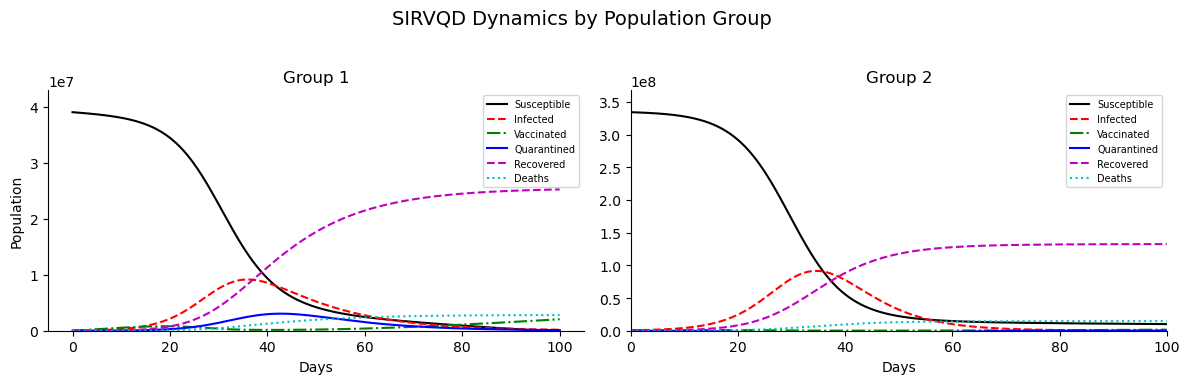

In [151]:
#Visualizes the disease dynamics
compartments_per_group = 17  
t_vals = np.arange(0, ND_end + t_inc, t_inc)

fig, axs = plt.subplots(1, num_groups, figsize=(6*num_groups, 4), sharey=False)

if num_groups == 1:
    axs = [axs]  # make iterable

for i in range(num_groups):
    offset = compartments_per_group * i
    S_total = RES_init[:, offset + 0] + RES_init[:, offset + 1] + RES_init[:, offset + 2] + RES_init[:, offset + 3]  # S_nt + S_wt + S_tp + S_tn
    I_total = RES_init[:, offset + 8] + RES_init[:, offset + 9] + RES_init[:, offset + 10]  # I_nt + I_wt + I_tn
    V_total = RES_init[:, offset + 4] + RES_init[:, offset + 5] + RES_init[:, offset + 6] + RES_init[:, offset + 7]  # V_nt + V_wt + V_tp + V_tn
    Q = RES_init[:, offset + 11]
    R = RES_init[:, offset + 12] + RES_init[:, offset + 13] + RES_init[:, offset + 14] + RES_init[:, offset + 15]  # all R types
    D = RES_init[:, offset + 16]

    axs[i].plot(t_vals, S_total, '-k', label='Susceptible')
    axs[i].plot(t_vals, I_total, '--r', label='Infected')
    axs[i].plot(t_vals, V_total, '-.g', label='Vaccinated')
    axs[i].plot(t_vals, Q, '-b', label='Quarantined')
    axs[i].plot(t_vals, R, '--m', label='Recovered')
    axs[i].plot(t_vals, D, ':c', label='Deaths')

    axs[i].set_title(f'Group {i+1}')
    axs[i].set_xlabel('Days')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].legend(fontsize=7)
    axs[i].set_ylim(0, max(np.max(S_total), np.max(I_total), np.max(V_total), np.max(Q), np.max(R), np.max(D)) * 1.1)

axs[0].set_ylabel('Population')
plt.suptitle("SIRVQD Dynamics by Population Group", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.xlim([0, ND_end])
plt.savefig("SIRVQD_N_groups.png", bbox_inches="tight")
plt.show()